# Steam Games Review Sentiment Analysis

In [17]:
%%capture
!pip install stopwords
!pip install flair
!pip install nltk
!pip install swifter

In [18]:
import pandas as pd
import numpy as np
import flair
from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score,roc_auc_score
pd.options.display.max_rows = None

### 2% off data to analyze and to be trained.

In [19]:
rn.seed(a=40)
p = 0.02  
review = pd.read_csv('steam_reviews.csv',skiprows=lambda i: i>0 and rn.random() > p)
review.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Graphics is not everything! :) Old school love.,1,1
1,10,Counter-Strike,Played it over 2000hours..woah.. all i can say...,1,0
2,10,Counter-Strike,Think you got skills because you came from CS:...,1,1
3,10,Counter-Strike,"Game of my childhood. It was the year 1998, i...",1,0
4,10,Counter-Strike,Where it all started :) A true classic to the ...,1,0


### 10% of data to be used as our model validation.

In [20]:
rn.seed(a=40)
q = 0.1  
review_val = pd.read_csv('steam_reviews.csv',skiprows=lambda i: i>0 and rn.random() > q)
review_val.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,This game saved my virginity.,1,0
1,10,Counter-Strike,Fire in the Hole Simulator 1999,1,0
2,10,Counter-Strike,Best game ever! Started my gaming addiction :D,1,1
3,10,Counter-Strike,'Lock and Load.' 'Go go go!' 'Fire in the hole...,1,0
4,10,Counter-Strike,Nice oldschool game! Counter-Strike is very co...,1,1


In [21]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128153 entries, 0 to 128152
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        128153 non-null  int64 
 1   app_name      124366 non-null  object
 2   review_text   128004 non-null  object
 3   review_score  128153 non-null  int64 
 4   review_votes  128153 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.9+ MB


In [22]:
review.review_text = review.review_text.astype('str')

# 3. Analysis and Visualization

## 3.1. Positive and Negative Sentiments

In [23]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


,review_score,review_text
1,1,104694
0,-1,23459


<AxesSubplot:xlabel='review_score', ylabel='count'>

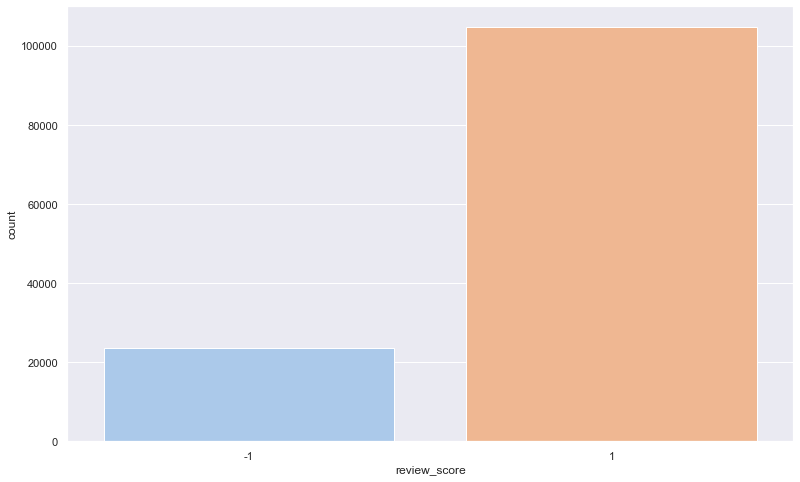

In [24]:
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

#### Bastante mais Reviews Positivas

## 3.2. WordCloud of Our Review Text

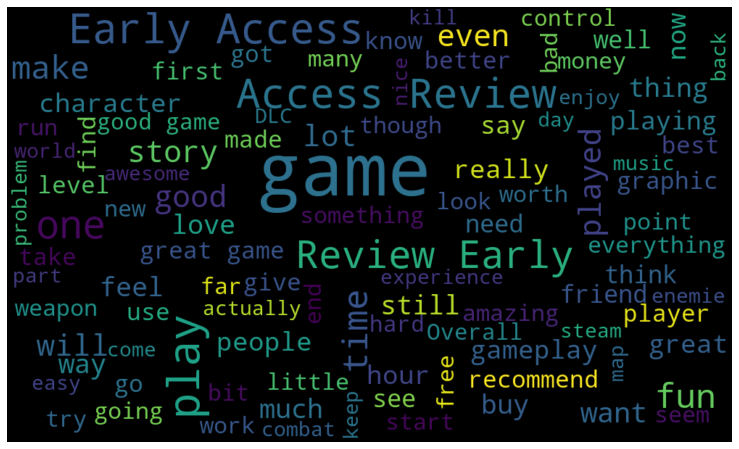

In [25]:
txt = ' '.join(rev for rev in review.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## 3.3. WordCloud of Each Sentiment Review Text

In [26]:
positive = review[review['review_score']==1]
negative = review[review['review_score']==-1]

## Positive Sentiment Reviews

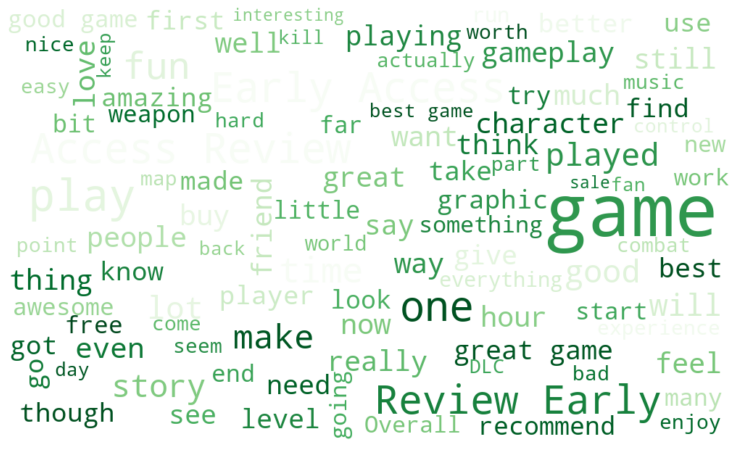

In [27]:
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            colormap='Greens',
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

###  positive sentiment review, palavras como 'good', 'best','great' 'amazing', 'fun' 

## Negative Sentiment Reviews

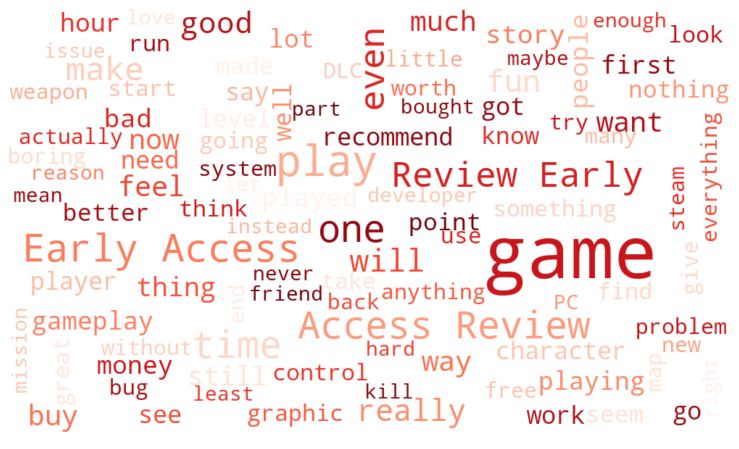

In [28]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            colormap='Reds',
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### For negative sentiment review, palavras como are 'boring', 'worth', 'bad', 'game'

In [29]:
review = review.drop(review[review.review_text == 'Early Access Review'].index)

## Distribuição do numero de palavras nas reviews

In [30]:
review_vis = review.copy()

In [31]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

### Than we can plot them

<AxesSubplot:xlabel='Num_word_review', ylabel='Count'>

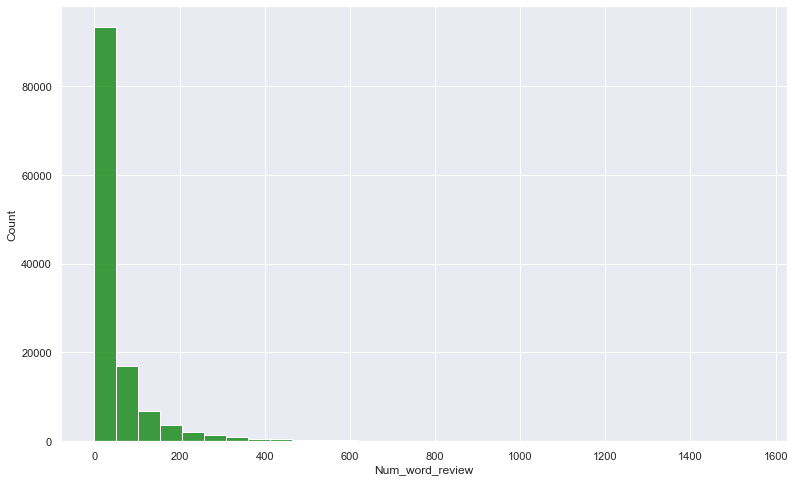

In [32]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

### A maior parte das reviews não contem mais de 200 palavras 

In [33]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,276424
1,and,186298
2,a,175388
3,to,174542
4,of,133863
5,is,123576
6,game,113869
7,I,112255
8,you,106759
9,it,85241


### Muitas StopWords que precisam de ser removidas

# 4. Data Cleaning For Sentiment Processing

In [34]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to C:\Users\Luís
[nltk_data]     Carneiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
review.isnull().sum()

app_id             0
app_name        3787
review_text        0
review_score       0
review_votes       0
dtype: int64

### Duplicate Values Removing

In [36]:
review = review.drop_duplicates(keep='first')

In [37]:
review.shape

(109075, 5)

### Função para limpar caracteres especiais 

In [38]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### Remover numeros pois estes não revelam sentimento  

In [39]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### Remover Emojis

In [40]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### Unir espaços 

In [41]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### Remover simbolos 

In [42]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### Remover Pontuação

In [43]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### E finalmente as Stopwords

In [44]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

## Stemming
### To put simply, stemming is the process of removing a part of a word, or reducing a word to its stem or root. This might not necessarily mean we’re reducing a word to its dictionary root. We use a few algorithms to decide how to chop a word off.

In [45]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('punkt')

from nltk import word_tokenize,sent_tokenize

def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

[nltk_data] Downloading package punkt to C:\Users\Luís
[nltk_data]     Carneiro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Função com todos os metodos criados anteriormente

In [46]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

In [47]:
cleaning(review,'review_text')

In [48]:
review[['review_text']].head(20)

,review_text
0,graphic everyth old school love
1,play hourswoah say isthisi old gold let go eve...
2,think got skill came cs go think got skill cau...
3,game childhood year pentium pc month upgrad dx...
4,start true classic counter strike seri never g...
5,play game year year non steam still amaz fact ...
6,old still best
7,nice game
8,great
9,play awesom game grow oh ya boy miss


In [49]:
review_vis2 = review.copy()

In [50]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,189136
1,play,55324
2,like,39450
3,get,33243
4,one,27061
5,good,26695
6,time,25745
7,fun,24913
8,realli,21775
9,great,21689


Agora com os dados limpos temos as palavras mais usadas nas reviews

### Plot 

<AxesSubplot:xlabel='count', ylabel='Common_words'>

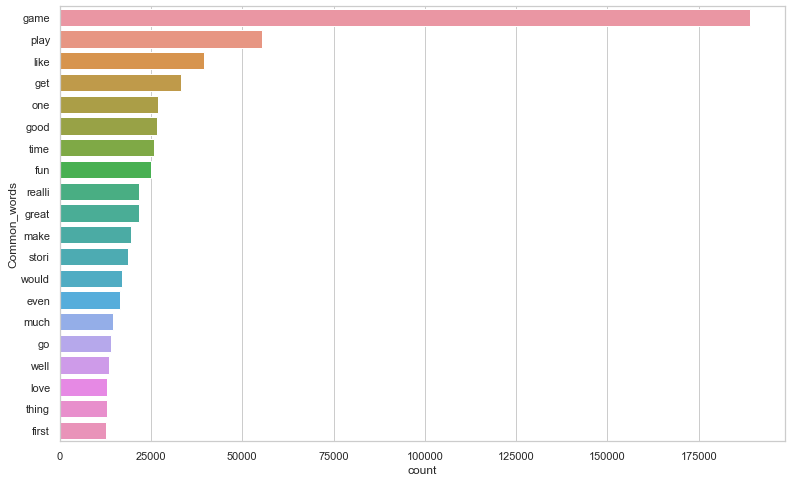

In [51]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

# 5. Creating Bag of Words and Text Classifier Model

## Tokenizing and Modelling

### Vectorizer para o tokenizing and random forest como modelo de classificação.

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=4000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

In [53]:
X = review['review_text']
y = review['review_score']

In [54]:
from collections import Counter
Counter(y)

Counter({1: 89326, -1: 19749})

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20)


In [56]:
text_classifier = clf.fit(X_train,y_train)

In [57]:
predictions = text_classifier.predict(X_test)

In [58]:
np.unique(predictions)

array([-1,  1], dtype=int64)

## 5.3. Model's Performance

In [59]:
# find accuracy, precision, recall:

confusion_matrix(y_test,predictions)

array([[ 1217,  2734],
       [  422, 17442]], dtype=int64)

In [60]:
def Confusion_Matrix(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('Confusion Matrix: \n',classification_report(y_test,ypred,labels=[1,-1]))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[1,0]))
    print('FN - False Negative {}'.format(cfmat[0,1]))
    print('TP - True Positive {}'.format(cfmat[0,0]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [61]:
Confusion_Matrix(y_test,predictions)

Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.86      0.98      0.92     17864
          -1       0.74      0.31      0.44      3951

    accuracy                           0.86     21815
   macro avg       0.80      0.64      0.68     21815
weighted avg       0.84      0.86      0.83     21815



TN - True Negative 17442
FP - False Positive 422
FN - False Negative 2734
TP - True Positive 1217
Accuracy Rate: 0.8553289021315609
Misclassification Rate: 0.14467109786843915
F1-Score: 0.6762275469376928
ROC-AUC 0.6422001782244497


<AxesSubplot:>

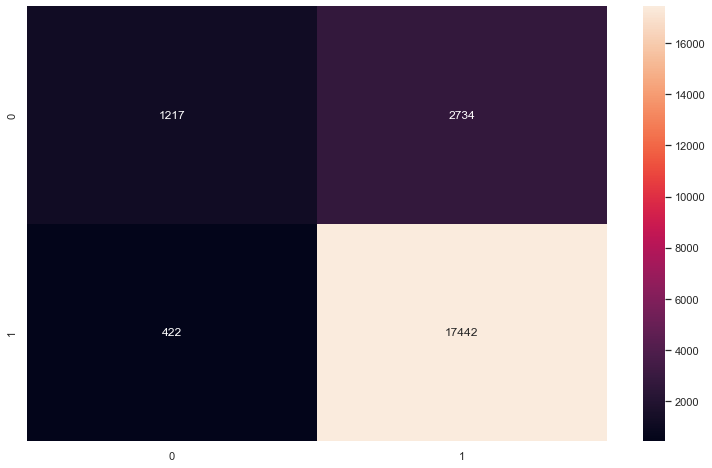

In [62]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='')

### F1-Score de 0.678 Data não é equilibrada.
### Fraco a prever a classe de reviews negativas  

### ROC-AUC score de 0.64 , pouca distinção 

UC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

##  Imbalanced Data Classes 

### Oversampling and undersampling para tentar melhorar a imbalanced data.

In [63]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

### Then we set our sampling strategy and variables needed in pipeline

In [64]:
strategy1 = {-1:40000}
strategy2 = {1:40000}

vect = CountVectorizer(stop_words= "english",max_features=3000)
tfidf = TfidfTransformer()
over = SMOTE(sampling_strategy=strategy1)
under = RandomUnderSampler(sampling_strategy=strategy2)
model = RandomForestClassifier()

In [65]:
X = review['review_text'].values
y = review['review_score'].values

In [66]:
Counter(y)

Counter({1: 89326, -1: 19749})

In [67]:
trf = vect.fit(X)
X = trf.transform(X)

In [68]:
steps = [('over', over), ('under', under)]
pipeline = PL(steps=steps)

In [69]:
X_new, y_new = pipeline.fit_resample(X, y)

In [70]:
counter_new = Counter(y_new)
print("Tweet Sentiment Class Proportion after oversampling and undersampling: \n",counter_new)

Tweet Sentiment Class Proportion after oversampling and undersampling: 
 Counter({-1: 40000, 1: 40000})


In [71]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y_new,random_state = 40,
                                                   test_size = 0.20)

### We prepare our original data (before oversampling and undersampling) as our evaluation data.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20)

In [73]:
Counter(y)

Counter({1: 89326, -1: 19749})

### Then we run our pipeline and train the model

In [74]:
pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
    ])

In [75]:
text_classifier2 = pipeline2.fit(X_train2,y_train2)

### Evaluation on original data

In [76]:
predictions2 = text_classifier2.predict(X_test)

In [77]:
Confusion_Matrix(y_test,predictions2)

Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.99      0.88      0.93     17864
          -1       0.63      0.94      0.76      3951

    accuracy                           0.89     21815
   macro avg       0.81      0.91      0.84     21815
weighted avg       0.92      0.89      0.90     21815



TN - True Negative 15695
FP - False Positive 2169
FN - False Negative 237
TP - True Positive 3714
Accuracy Rate: 0.8897089158835664
Misclassification Rate: 0.11029108411643365
F1-Score: 0.8420733820429667
ROC-AUC 0.9092989051505664


<AxesSubplot:>

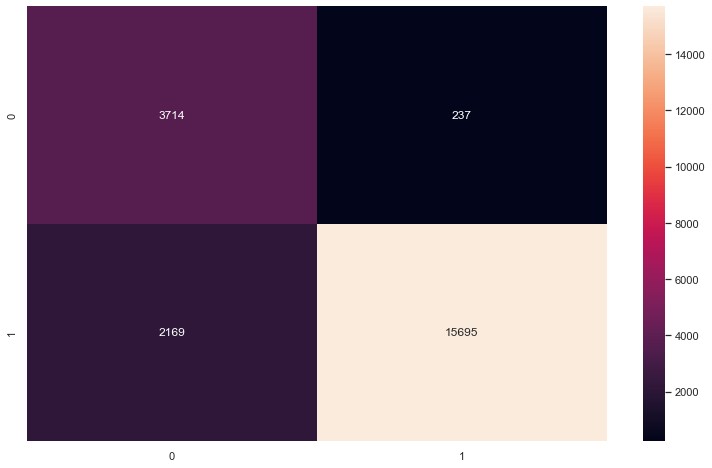

In [78]:
sns.heatmap(confusion_matrix(y_test,predictions2),annot=True,fmt='')

### Com estes metódos podemos concluir que obtemos muito melhor onde temos F1-Score of 0.83. e ROC-AUC de 0.9 agora o model pode entao distinguir bem a classe positiva da negativa



In [81]:
import pickle


pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(TfidfVectorizer, open('vectorization.pkl', 'wb'))